# Spatial Data Tools - Working with Spatial Data in Python

**Translated from R by:** Claude AI & Shaonlee Patranabis 
**Original Author:** Martina Pardy  
**Date:** 2025-10-31

---

This tutorial introduces key workflows for reading, merging, and visualizing and analysing spatial data in Python using the packages: **geopandas**, **rasterio**, **xarray**, **matplotlib**, **rasterstats**, and **statsmodels**. It shows how to read in spatial data, do spatial joins and plot spatial data.

This is a Python translation of the original R tutorial.

---

## 1. Key Packages

| Package | Purpose | Key Functions | R Equivalent |
|----------|----------|---------------|-------------|
| **geopandas** | Handling *vector data* (points, lines, polygons) with pandas-like interface | `read_file()`, `sjoin()`, `to_crs()`, `dissolve()` | sf |
| **rasterio** | Reading and writing *raster* data | `open()`, `read()`, `mask()`, `warp.reproject()` | terra |
| **xarray** | Working with multi-dimensional arrays (NetCDF, etc.) | `open_dataset()`, `sel()`, `mean()` | terra |
| **rioxarray** | Geospatial extension for xarray with rasterio integration | `open_rasterio()`, `rio.reproject()`, `rio.clip()` | terra |
| **xvec** | Vector-raster operations directly with xarray | `zonal_stats()`, `extract_points()` | terra/exactextractr |
| **exactextract** | Fast and accurate extraction of raster values to polygons with area-weighting | `exact_extract()` | exactextractr |
| **rasterstats** | Extract raster values to vector geometries with statistics | `zonal_stats()` | exactextractr |
| **matplotlib** | Visualization and plotting | `pyplot.plot()`, `pyplot.imshow()` | ggplot2 |
| **folium** | Interactive web maps | `Map()`, `Choropleth()` | tmap/leaflet |
| **statsmodels** | Statistical modeling and econometrics | `OLS()`, `summary()` | fixest |
| **linearmodels** | Panel data models with fixed effects | `PanelOLS()` | fixest |

---

In [73]:
# Install required packages (uncomment if needed)
# %pip install geopandas rasterio xarray rioxarray xvec exactextract rasterstats matplotlib folium statsmodels linearmodels netCDF4 affine

## 2. Reading Spatial Data

### Shapefiles or geopackages using `geopandas`

`read_file()` to read in vector data.

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Read in LSOA shapefile
lsoa_shp = gpd.read_file("Data\LSOA_withdata.shp")

In [5]:
# Check geometries in shapefile
print(lsoa_shp.geom_type.unique())

['Polygon' 'MultiPolygon']


In [6]:
# Have a look at the data
lsoa_shp.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,lsoacode,population,populati_1,loneparent,ukbornpc,privateren,...,collegepc,lsoaname,property_c,routine_oc,prof_occup,notworking,propcrime_,log_propcr,areanew,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E01000001,1472,117,2.6,67.3,30.1,...,77.6,City of London 001A,366,3.7,43.4,1.7,2486.4130,7.818596,133369.917,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,E02000001,City of London 001,E01000002,1438,141,2.7,73.0,26.4,...,79.2,City of London 001B,292,4.0,43.3,0.9,2030.5980,7.616086,226274.233,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E01000003,1348,99,6.0,67.5,21.7,...,56.8,City of London 001C,69,14.0,25.2,4.6,511.8694,6.238070,57324.070,"POLYGON ((532135.145 182198.119, 532158.25 182..."
3,E01000005,City of London 001E,E02000001,City of London 001,E01000005,987,161,9.4,60.7,21.6,...,34.5,City of London 001E,426,28.4,11.5,12.4,4316.1090,8.370110,190807.235,"POLYGON ((533807.946 180767.77, 533649.063 180..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E01000006,1731,401,9.9,48.7,32.8,...,32.9,Barking and Dagenham 016A,67,25.0,8.7,13.0,387.0595,5.958579,144236.456,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [7]:
# Inspect
print(f"Shape: {lsoa_shp.shape}") # Check the shape (rows x columns)
print(f"CRS: {lsoa_shp.crs}")

Shape: (4835, 25)
CRS: EPSG:7405


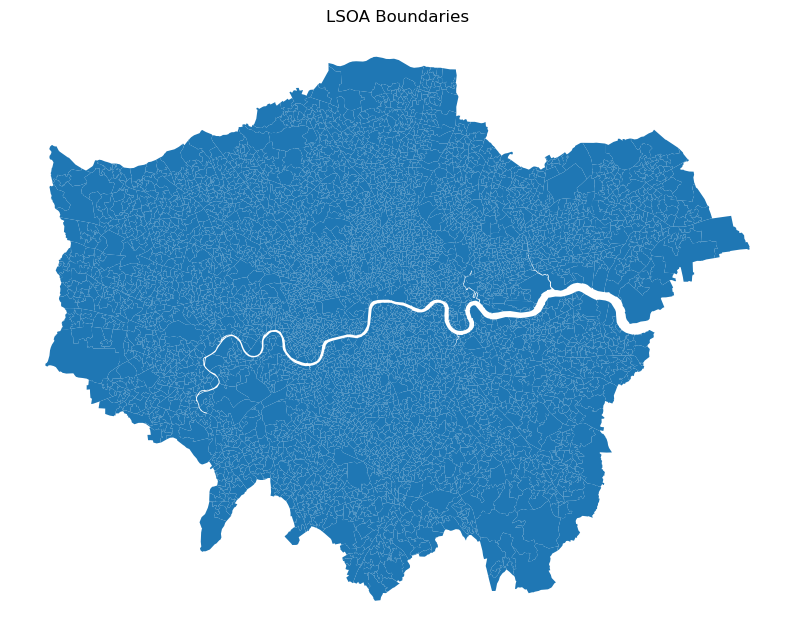

In [8]:
# Plot geometries
lsoa_shp.plot(figsize=(10, 10))
plt.title("LSOA Boundaries")
plt.axis('off')
plt.show()

### Raster data with `xarray` and `rasterio`

`open_dataset()` to read in NetCDF raster data.  
`rio.clip()` to crop the raster to a specific extent.  
`where()` to mask values outside a condition.

In [9]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import netCDF4

In [10]:
# Open the temperature data set
tmp = xr.open_dataset(
    r"Data\tas_hadukgrid_uk_1km_ann_202301-202312.nc"
)

In [11]:
# Check the CRS of your loaded data
print(tmp.rio.crs)

# If it's not already set, you can assign it:
tmp = tmp.rio.write_crs("EPSG:27700")

print(tmp.rio.crs)

None
EPSG:27700


In [12]:
import rasterio
from rasterio.enums import Resampling
# Read the original NetCDF with proper orientation
tmp_reproj = tmp['tas'].rio.reproject(
    "EPSG:27700",
    resampling=Resampling.bilinear
).sortby('y', ascending=False)  # Sort Y in descending order


# Dataset from here: https://www.metoffice.gov.uk/research/climate/maps-and-data/data/haduk-grid/datasets

In [13]:
# Save
tmp_reproj.rio.to_raster(r"Data/temp_raster.tif")

# Verify the bounds are correct
with rasterio.open(r"Data/temp_raster.tif") as src:
    print("New raster bounds:", src.bounds)

New raster bounds: BoundingBox(left=-200000.0, bottom=-200000.0, right=700000.0, top=1250000.0)


In [14]:
print(tmp)
print("\nTemperature statistics:")
print(f"Shape: {tmp['tas'].values.shape}")  # Show dimensions instead
print(f"Mean: {np.nanmean(tmp['tas'].values):.2f}°C") 
print(f"Min: {np.nanmin(tmp['tas'].values):.2f}°C")
print(f"Max: {np.nanmax(tmp['tas'].values):.2f}°C")

<xarray.Dataset> Size: 31MB
Dimensions:                       (time: 1, projection_y_coordinate: 1450,
                                   projection_x_coordinate: 900, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 8B 2023-07-01
  * projection_y_coordinate       (projection_y_coordinate) float64 12kB -1.9...
  * projection_x_coordinate       (projection_x_coordinate) float64 7kB -1.99...
    transverse_mercator           int64 8B 0
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 10MB ...
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 10MB ...
Dimensions without coordinates: bnds
Data variables:
    tas                           (time, projection_y_coordinate, projection_x_coordinate) float64 10MB ...
    time_bnds                     (time, bnds) datetime64[ns] 16B ...
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 23kB ...
    projection_

In [15]:
# Mask to only land values (assuming NaN values are water/non-land)
tmp_masked = tmp['tas'].where(tmp['tas'].notnull())

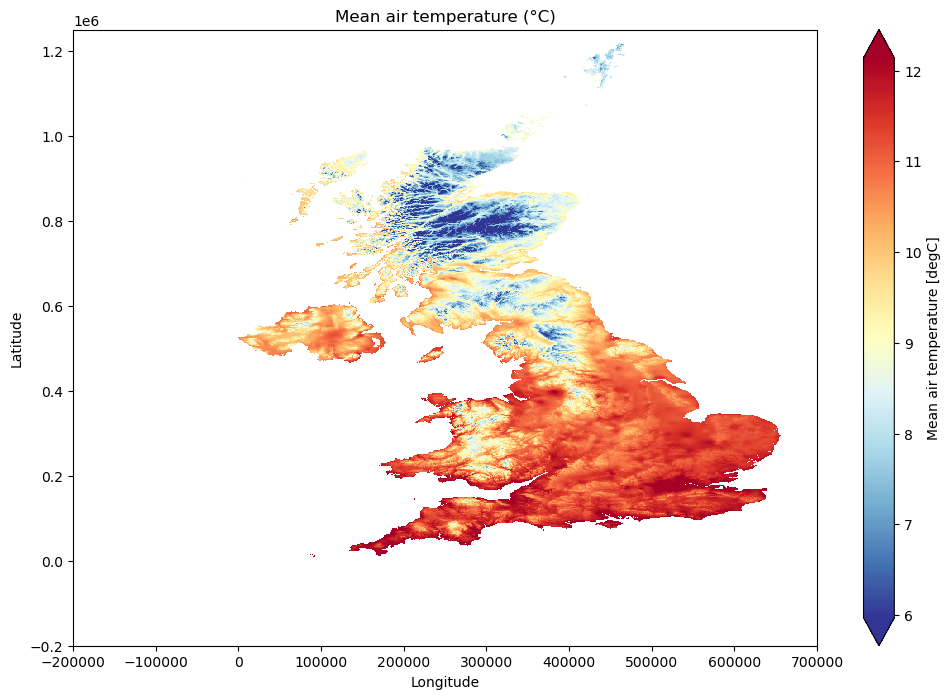

In [16]:
# Plot raster data
plt.figure(figsize=(12, 8))
tmp_masked.plot(cmap='RdYlBu_r', robust=True)
plt.title("Mean air temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Tabular data with `pandas`

In [17]:
import pandas as pd

# Read deprivation data
depriv_england = pd.read_csv(
    "Data\Indices_of_Multiple_Deprivation_(IMD)_2019_7433421139510038074.csv"
)
# Data from here: https://data.catchmentbasedapproach.org/datasets/45e05901e0a14cca9ab180975e2e8194_0/about

print(f"Shape: {depriv_england.shape}")
print("\nFirst few rows:")
depriv_england.head()

Shape: (32844, 66)

First few rows:


,FID,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,...,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,Shape__Area,Shape__Length
0,1,E01001631,Greenwich 007B,Greenwich 007B,193021.165975,1975.779670,6211,2,Greenwich 007B,E09000011,...,1.087,3567,2,2260,637,1457,166,1424.00,497247.788158,3171.459454
1,2,E01001632,Greenwich 007C,Greenwich 007C,121408.158584,1898.130536,15631,5,Greenwich 007C,E09000011,...,0.598,7446,3,2624,573,1825,226,1812.50,312708.081928,3046.352281
2,3,E01001633,Greenwich 009B,Greenwich 009B,115275.919076,2473.511213,6202,2,Greenwich 009B,E09000011,...,0.838,5339,2,1663,424,1037,202,1038.25,296893.243816,3970.188649
3,4,E01001634,Greenwich 009C,Greenwich 009C,117129.660883,2390.527230,3802,2,Greenwich 009C,E09000011,...,0.714,6372,2,1740,450,1045,245,1022.50,301698.816494,3835.513016
4,5,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,29199,9,City of London 001A,E09000001,...,1.503,1615,1,1296,175,656,465,715.00,343907.419830,3682.439420


In [18]:
# Distribution of IMD scores
print("\nIMD Score statistics:")
print(depriv_england['IMDScore'].describe())


IMD Score statistics:
count    32844.000000
mean        21.669393
std         15.332229
min          0.541000
25%          9.913750
50%         17.647500
75%         29.583000
max         92.735000
Name: IMDScore, dtype: float64


## 3. Coordinate Reference Systems (CRS)

In [ ]:

# Check CRS
print(f"Raster CRS: {tmp.rio.crs}")
print(f"Shapefile CRS: {lsoa_shp.crs}")

# Only assign CRS if it's missing (check first)
if tmp.rio.crs is None:
    tmp = tmp.rio.write_crs("EPSG:27700")
    print("Assigned CRS to raster")

# Reproject shapefile to British National Grid (EPSG:27700)
lsoa_shp = lsoa_shp.to_crs("EPSG:27700")

# Reproject raster data to British National Grid (EPSG:27700)
# Only reproject if needed
if tmp['tas'].rio.crs != "EPSG:27700":
    tmp_reproj = tmp['tas'].rio.reproject("EPSG:27700", resampling=Resampling.bilinear)
else:
    tmp_reproj = tmp['tas']

print("\nReprojected temperature statistics:")
print(f"Mean: {np.nanmean(tmp_reproj.values):.2f}°C")
print(f"Raster CRS: {tmp_reproj.rio.crs}")
print(f"Shapefile CRS: {lsoa_shp.crs}")

Raster CRS: EPSG:27700
Shapefile CRS: EPSG:7405

Reprojected temperature statistics:
Mean: 9.98°C
Raster CRS: EPSG:27700
Shapefile CRS: EPSG:27700


## 4. Spatial Join

In [20]:
lsoa_shp.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,lsoacode,population,populati_1,loneparent,ukbornpc,privateren,...,collegepc,lsoaname,property_c,routine_oc,prof_occup,notworking,propcrime_,log_propcr,areanew,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E01000001,1472,117,2.6,67.3,30.1,...,77.6,City of London 001A,366,3.7,43.4,1.7,2486.4130,7.818596,133369.917,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,E02000001,City of London 001,E01000002,1438,141,2.7,73.0,26.4,...,79.2,City of London 001B,292,4.0,43.3,0.9,2030.5980,7.616086,226274.233,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E01000003,1348,99,6.0,67.5,21.7,...,56.8,City of London 001C,69,14.0,25.2,4.6,511.8694,6.238070,57324.070,"POLYGON ((532135.145 182198.119, 532158.25 182..."
3,E01000005,City of London 001E,E02000001,City of London 001,E01000005,987,161,9.4,60.7,21.6,...,34.5,City of London 001E,426,28.4,11.5,12.4,4316.1090,8.370110,190807.235,"POLYGON ((533807.946 180767.77, 533649.063 180..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E01000006,1731,401,9.9,48.7,32.8,...,32.9,Barking and Dagenham 016A,67,25.0,8.7,13.0,387.0595,5.958579,144236.456,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [22]:
# Attribute join using pandas merge (equivalent to dplyr left_join)
lsoa_depr = lsoa_shp.merge(
    depriv_england,
    left_on='LSOA11CD', # lsoa codes in our shapefile
    right_on='lsoa11cd', # lsoa codes in IMD data
    how='left'
)

print(f"Joined data shape: {lsoa_depr.shape}")
print("\nData info:")
print(lsoa_depr.info())

# Examples of spatial joins with geopandas:

# Join points to polygons they fall within:
# gpd.sjoin(stores_points, neighborhood_polygons, predicate='within')

# Find which census tract each crime occurred in:
# gpd.sjoin(crime_points, census_tracts, predicate='within')

# Find overlapping polygons:
# gpd.sjoin(parcels, flood_zones, predicate='intersects')

# Common spatial predicates for sjoin():
# - 'intersects': features that touch or overlap (default)
# - 'within': features completely inside
# - 'contains': features that contain others
# - 'overlaps': features that partially overlap

# For distance-based joins, use buffer first:
# schools_buffer = schools.buffer(500)
# gpd.sjoin(schools_buffer, parks, predicate='intersects')

Joined data shape: (4835, 91)

Data info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 91 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   LSOA11CD       4835 non-null   object  
 1   LSOA11NM       4835 non-null   object  
 2   MSOA11CD       4835 non-null   object  
 3   MSOA11NM       4835 non-null   object  
 4   lsoacode       4835 non-null   object  
 5   population     4835 non-null   int32   
 6   populati_1     4835 non-null   int32   
 7   loneparent     4835 non-null   float64 
 8   ukbornpc       4835 non-null   float64 
 9   privateren     4835 non-null   float64 
 10  medianhpri     4835 non-null   int32   
 11  socialrent     4835 non-null   float64 
 12  onepersonh     4835 non-null   float64 
 13  populati_2     4835 non-null   int32   
 14  density        4835 non-null   int32   
 15  collegepc      4835 non-null   float64 
 16  lsoaname       4831 non-null

## 5. Extract Raster Values to Polygons

In [24]:
# Reload the raster
tas_raster = rxr.open_rasterio(r"Data/temp_raster.tif", masked=True)

# Crop to shapefile bounds with a buffer
lsoa_bounds = lsoa_shp.total_bounds  # [minx, miny, maxx, maxy]
buffer = 5000  # 5km buffer

clipped_raster = tas_raster.rio.clip_box(
    minx=lsoa_bounds[0] - buffer,
    miny=lsoa_bounds[1] - buffer,
    maxx=lsoa_bounds[2] + buffer,
    maxy=lsoa_bounds[3] + buffer
)

# Save the cropped raster
clipped_raster.rio.to_raster(r"Data/temp_raster_cropped.tif")

print(f"Cropped raster saved")
print(f"Original shape: {tas_raster.shape}")
print(f"Cropped shape: {clipped_raster.shape}")

Cropped raster saved
Original shape: (1, 1450, 900)
Cropped shape: (1, 56, 69)


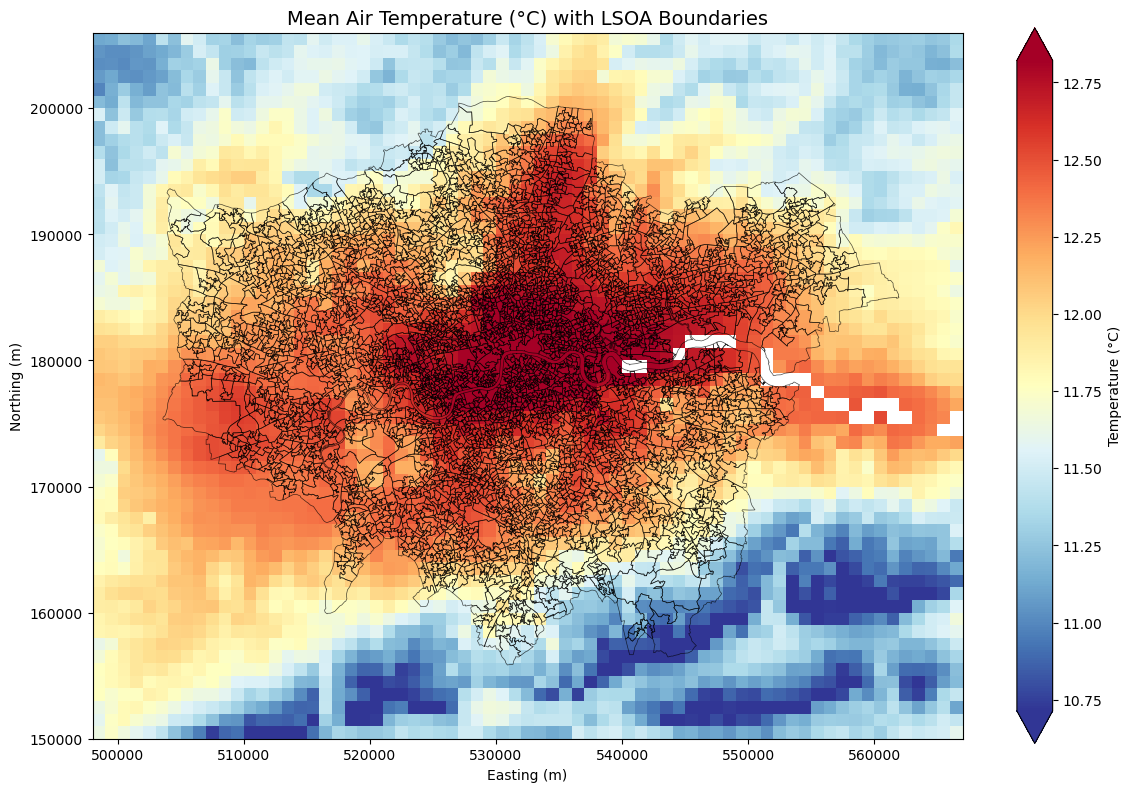

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot raster first
clipped_raster.plot(
    ax=ax,
    cmap='RdYlBu_r',
    robust=True,
    add_colorbar=True,
    cbar_kwargs={'label': 'Temperature (°C)'}
)

# Plot shapefile boundaries on top
lsoa_shp.plot(
    ax=ax,
    facecolor='none',  # Transparent fill
    edgecolor='black',  # Black outlines
    linewidth=0.5,
    alpha=0.7
)

ax.set_title("Mean Air Temperature (°C) with LSOA Boundaries", fontsize=14)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()

#### Option 1 - Using `xvec`

In [26]:
import xarray as xr
import geopandas as gpd
import xvec

In [ ]:
# Convert xarray to rasterio-compatible format
# First, save the reprojected raster temporarily
tmp_reproj.rio.to_raster(r"Data/temp_raster.tif")

In [28]:
# Load raster as xarray (not rioxarray)
tmp = xr.open_dataset(r"Data\tas_hadukgrid_uk_1km_ann_202301-202312.nc")
tas = tmp['tas']

In [29]:
# Set CRS if needed
if not hasattr(tas, 'spatial_ref'):
    tas = tas.rio.write_crs("EPSG:27700")

In [30]:
# Check the coordinate names in your dataset
print("Dataset coordinates:")
print(tas.coords)
print("\nDataset dimensions:")
print(tas.dims)

Dataset coordinates:
Coordinates:
  * time                     (time) datetime64[ns] 8B 2023-07-01
  * projection_y_coordinate  (projection_y_coordinate) float64 12kB -1.995e+0...
  * projection_x_coordinate  (projection_x_coordinate) float64 7kB -1.995e+05...
    latitude                 (projection_y_coordinate, projection_x_coordinate) float64 10MB ...
    longitude                (projection_y_coordinate, projection_x_coordinate) float64 10MB ...
    transverse_mercator      int64 8B 0

Dataset dimensions:
('time', 'projection_y_coordinate', 'projection_x_coordinate')


In [31]:
#Extract at geometry (zonal mean)
lsoa_shp_xvec = lsoa_shp.set_index('LSOA11CD')
extracted = tas.xvec.zonal_stats(
    lsoa_shp_xvec.geometry,
    x_coords="projection_x_coordinate",
    y_coords="projection_y_coordinate", 
    stats="mean"
)

In [32]:
print(extracted)

# Convert to dataframe
result_df = extracted.to_dataframe().reset_index()
print(result_df.head())

<xarray.DataArray 'tas' (geometry: 4835, time: 1)> Size: 39kB
array([[        nan],
       [        nan],
       [        nan],
       ...,
       [12.72068099],
       [12.70466718],
       [        nan]], shape=(4835, 1))
Coordinates:
  * geometry             (geometry) geometry 39kB POLYGON ((532105.0919998939...
  * time                 (time) datetime64[ns] 8B 2023-07-01
    transverse_mercator  int64 8B 0
    LSOA11CD             (geometry) object 39kB 'E01000001' ... 'E01033746'
Indexes:
    geometry  GeometryIndex (crs=EPSG:27700)
Attributes:
    standard_name:  air_temperature
    long_name:      Mean air temperature
    units:          degC
    description:    Mean air temperature
    label_units:    °C
    level:          1.5m
    plot_label:     Mean air temperature at 1.5m (°C)
    cell_methods:   time: mid_range within days time: mean over days
                                            geometry       time  \
0  POLYGON ((532105.092 182011.23, 532162.491 181... 2023-07-0

In [56]:
# Convert to dataframe
result_df = extracted.to_dataframe().reset_index()

In [57]:
z_stats = gpd.GeoDataFrame(result_df)

In [58]:
z_stats

,geometry,time,transverse_mercator,LSOA11CD,tas
0,"POLYGON ((532105.092 182011.23, 532162.491 181...",2023-07-01,0,E01000001,NaN
1,"POLYGON ((532746.813 181786.891, 532671.688 18...",2023-07-01,0,E01000002,NaN
2,"POLYGON ((532135.145 182198.119, 532158.25 182...",2023-07-01,0,E01000003,NaN
3,"POLYGON ((533807.946 180767.77, 533649.063 180...",2023-07-01,0,E01000005,12.878875
4,"POLYGON ((545122.049 184314.931, 545271.917 18...",2023-07-01,0,E01000006,NaN
...,...,...,...,...,...
4830,"POLYGON ((544642.68 179824.674, 544766.313 179...",2023-07-01,0,E01033742,NaN
4831,"POLYGON ((546579.195 181097.813, 546687.036 18...",2023-07-01,0,E01033743,12.701736
4832,"POLYGON ((544536.486 179447.115, 544602.63 179...",2023-07-01,0,E01033744,12.720681
4833,"POLYGON ((546415.745 180152.27, 546320.715 180...",2023-07-01,0,E01033745,12.704667


<Axes: >

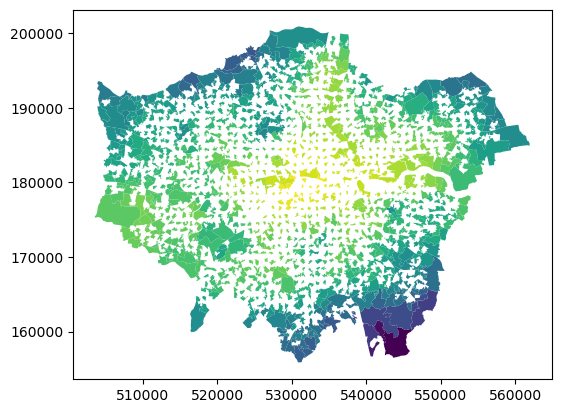

In [ ]:
z_stats.plot(column = 'tas') # quick visualisation

### Option 2 - Using `exactextract`

In [63]:
import exactextract
import geopandas as gpd
import rasterio

In [64]:
# Load your data
lsoa_shp = gpd.read_file(r"Data/LSOA_withdata.shp").to_crs("EPSG:27700")

# Open the raster
with rasterio.open(r"Data/temp_raster.tif") as src:
    # Extract zonal statistics
    stats = exactextract.exact_extract(
        src,
        lsoa_shp,
        ['mean', 'min', 'max', 'count'],
        include_cols=['LSOA11CD'],  # Include this column from the shapefile
        output='pandas'
    )


In [65]:
print(stats.head())

# Merge back to GeoDataFrame
z_stats = lsoa_shp.merge(stats, on='LSOA11CD', how='left')


    LSOA11CD       mean        min        max     count
0  E01000001  12.856760  12.855342  12.892339  0.133321
1  E01000002  12.855345  12.855342  12.883914  0.226191
2  E01000003  12.872277  12.855342  12.883914  0.057303
3  E01000005  12.910273  12.878875  12.984741  0.190739
4  E01000006  12.634744  12.629482  12.646464  0.144196


<Axes: >

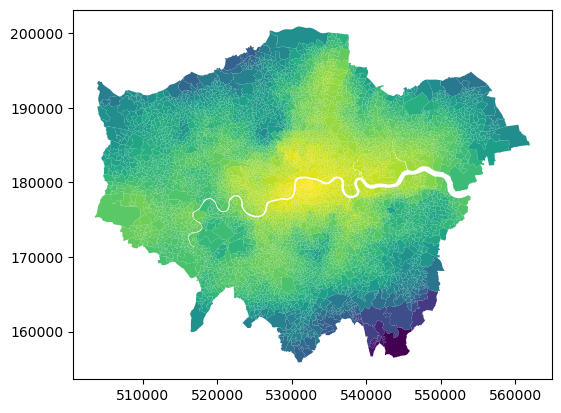

In [67]:
# Quick little viz
z_stats.plot(column = 'mean')

## Comparison: xvec vs exactextract for Zonal Statistics

### **exactextract** - Best for small polygons relative to pixel size

**Advantages:**
- ✅ **More accurate** - uses area-weighted statistics (accounts for partial pixel coverage)
- ✅ **Better for small polygons** - when polygons are smaller than raster pixels (like our LSOAs)
- ✅ **Proven algorithm** - based on R's exactextractr which is the gold standard
- ✅ **Handles edge cases** - better at polygon boundaries

**Disadvantages:**
- ❌ Requires saving raster to file first (extra I/O)
- ❌ Works with rasterio, not directly with xarray
- ❌ Less flexible for multi-dimensional data

---

### **xvec** - Best for large datasets, time series, or lazy evaluation

**Advantages:**
- ✅ **Works directly with xarray** - no need to save intermediate files
- ✅ **Handles multi-dimensional data** easily (time, bands, etc.)
- ✅ **Lazy evaluation** with dask - can process huge datasets
- ✅ **More Pythonic** - integrated xarray workflow
- ✅ **Faster for large datasets** - especially with dask

**Disadvantages:**
- ❌ Less accurate for small polygons (simple pixel center method by default)
- ❌ Doesn't do area-weighting as precisely

---

### **When to use which?**

**Use exactextract when:**
- Polygons are small relative to pixel size ✅ **(OUR CASE: LSOAs < 1km pixels)**
- You need maximum accuracy
- Single time step / single band
- You already have files saved

**Use xvec when:**
- Working with time series or multi-band data
- Large datasets that benefit from lazy evaluation
- You want to stay in the xarray ecosystem
- Speed matters more than sub-pixel accuracy
- Polygons are large relative to pixels

---

**For this London temperature analysis, exactextract was the right choice!** Our LSOA polygons are smaller than the 1km raster pixels, so area-weighted averaging matters for accuracy.

## 6. Visualizing Spatial Data

### (a) Choropleth Map

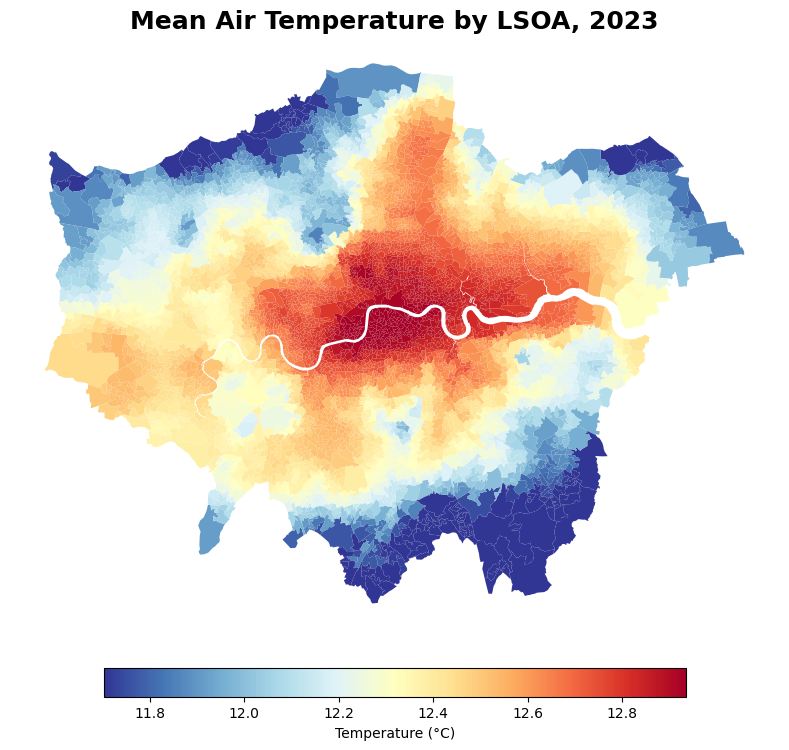

In [72]:
# Create choropleth map
fig, ax = plt.subplots(figsize=(10, 8))

z_stats.plot(
    column='mean',
    ax=ax,
    cmap='RdYlBu_r',
    edgecolor='none',
    linewidth=0.5,
    legend=True,
    legend_kwds={
        'label': 'Temperature (°C)',
        'orientation': 'horizontal',
        'pad': 0.05,
        'shrink': 0.6
    },
    vmin=z_stats['mean'].quantile(0.02),  # Remove outliers for better color scale
    vmax=z_stats['mean'].quantile(0.98)
)

ax.set_title('Mean Air Temperature by LSOA, 2023', fontsize=18, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

### (b) Using matplotlib with viridis colormap

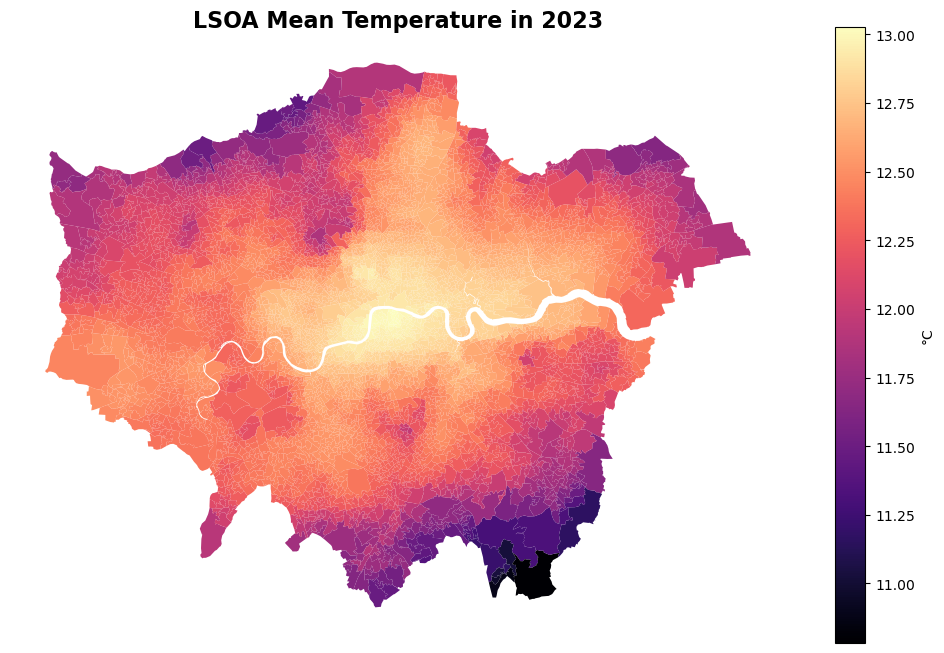

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

z_stats.plot(
    column='mean',  # Changed from 'mean' to 'tas'
    ax=ax,
    legend=True,
    cmap='magma',
    edgecolor='none',
    missing_kwds={'color': 'lightgrey'},
    legend_kwds={
        'label': '°C',
        'orientation': 'vertical',
        'shrink': 0.8
    }
)

ax.set_title('LSOA Mean Temperature in 2023', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis('off')

plt.tight_layout()
plt.show()

### (c) Interactive map with folium (bonus!)

## 7. Regression Analysis

Once you've worked with spatial data, you'll often want to analyze relationships between variables. Here we use **statsmodels** for regression estimation with the built-in `mtcars` dataset.

In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Load mtcars dataset (available in statsmodels.datasets)
from statsmodels.datasets import get_rdataset
mtcars = get_rdataset('mtcars').data

print("First few rows of mtcars:")
print(mtcars.head())

# Model 1: Effect of weight on fuel efficiency
m1 = smf.ols('mpg ~ wt', data=mtcars).fit()

# Model 2: Multiple predictors
m2 = smf.ols('mpg ~ wt + hp', data=mtcars).fit()

# Model 3: With fixed effects by number of cylinders
m3 = smf.ols('mpg ~ wt + hp + C(cyl)', data=mtcars).fit()

# Model 4: With robust/clustered standard errors
m4 = smf.ols('mpg ~ wt + hp + C(cyl)', data=mtcars).fit(
    cov_type='cluster',
    cov_kwds={'groups': mtcars['gear']}
)

# Display results in a formatted table
results_table = summary_col(
    [m1, m2, m3, m4],
    stars=True,
    float_format='%.3f',
    model_names=['Model 1', 'Model 2', 'Fixed Effects', 'Clustered SE'],
    info_dict={
        'N': lambda x: f"{int(x.nobs)}",
        'R2': lambda x: f"{x.rsquared:.3f}"
    }
)

print(results_table)

First few rows of mtcars:
                    mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
rownames                                                                     
Mazda RX4          21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
Mazda RX4 Wag      21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
Datsun 710         22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
Hornet 4 Drive     21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

                   carb  
rownames                 
Mazda RX4             4  
Mazda RX4 Wag         4  
Datsun 710            1  
Hornet 4 Drive        1  
Hornet Sportabout     2  

                Model 1   Model 2  Fixed Effects Clustered SE
-------------------------------------------------------------
Intercept      37.285*** 37.227*** 35.846***     35.846***   
               (1.878)   (1.599)   (2.041)       (3.607)  

### Alternative: Panel data models with fixed effects using linearmodels

In [40]:
# For more advanced fixed effects models (closer to fixest in R)
from linearmodels import PanelOLS

# Prepare data for panel regression (needs MultiIndex)
mtcars_panel = mtcars.copy()
mtcars_panel['id'] = range(len(mtcars_panel))
mtcars_panel = mtcars_panel.set_index(['cyl', 'id'])

# Panel regression with entity (cyl) fixed effects
panel_model = PanelOLS(
    mtcars_panel['mpg'],
    mtcars_panel[['wt', 'hp']],
    entity_effects=True
).fit(cov_type='clustered', cluster_entity=True)

print(panel_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    mpg   R-squared:                        0.4663
Estimator:                   PanelOLS   R-squared (Between):             -1.5641
No. Observations:                  32   R-squared (Within):               0.4663
Date:                Thu, Oct 30 2025   R-squared (Overall):             -1.6076
Time:                        18:12:23   Log-likelihood                   -71.235
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.796
Entities:                           3   P-value                           0.0002
Avg Obs:                       10.667   Distribution:                    F(2,27)
Min Obs:                       7.0000                                           
Max Obs:                       14.000   F-statistic (robust):             2381.6
                            

### Export results to LaTeX

In [41]:
# Export regression table to LaTeX format
latex_output = results_table.as_latex()
print(latex_output)

# Save to file
with open('regression_results.tex', 'w') as f:
    f.write(latex_output)

print("\nResults saved to regression_results.tex")

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
               & Model 1   & Model 2   & Fixed Effects & Clustered SE  \\
\hline
Intercept      & 37.285*** & 37.227*** & 35.846***     & 35.846***     \\
               & (1.878)   & (1.599)   & (2.041)       & (3.607)       \\
wt             & -5.344*** & -3.878*** & -3.181***     & -3.181***     \\
               & (0.559)   & (0.633)   & (0.720)       & (0.985)       \\
hp             &           & -0.032*** & -0.023*       & -0.023*       \\
               &           & (0.009)   & (0.012)       & (0.012)       \\
C(cyl)[T.6]    &           &           & -3.359**      & -3.359***     \\
               &           &           & (1.402)       & (0.431)       \\
C(cyl)[T.8]    &           &           & -3.186        & -3.186        \\
               &           &           & (2.170)       & (2.362)       \\
R-squared      & 0.753     & 0.827     & 0.857         & 0.857         \\
R-squared Adj. & 0.745    

## 8. More Tips and Resources

Always check CRS before spatial operations.

**Python Spatial Data Resources:**

GeoPandas Documentation:
- https://geopandas.org/en/stable/

Rasterio Documentation:
- https://rasterio.readthedocs.io/

Working with raster data in Python:
- https://geohackweek.github.io/raster/
- https://carpentries-incubator.github.io/geospatial-python/

Geocomputation with Python:
- https://py.geocompx.org/

Python for Geographic Data Analysis:
- https://pythongis.org/

Statsmodels Documentation:
- https://www.statsmodels.org/stable/index.html

LinearModels (Panel Data):
- https://bashtage.github.io/linearmodels/

**Key Differences from R:**
- `sf` → `geopandas`
- `terra` → `rasterio` + `xarray`
- `ggplot2` → `matplotlib` / `seaborn` / `plotly`
- `tmap` → `folium` (interactive) or `matplotlib` (static)
- `fixest` → `statsmodels` / `linearmodels`
- `exactextractr` → `exactextract` or `xvec`